# Visualizing WIT (Wikipedia Images and Text) database using CLIP embeddings

This example creates an index on the Clip embeddings, solve searches, and also produce UMAP visualizations.

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto, e.g., start the jupyter 

```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```

_june 3rd, 2023: working with `SimilaritySearch` v0.10. I also changed from `Plots` to `Makie`._

In [1]:
using Pkg
Pkg.activate(".")
if !isfile("Manifest.toml")
    Pkg.add([
        PackageSpec(name="SimilaritySearch", version="0.10"),
        PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
        PackageSpec(name="CairoMakie"),
        PackageSpec(name="ColorSchemes"),
        PackageSpec(name="Colors"),
        PackageSpec(name="DataFrames"),
        PackageSpec(name="CSV"),
        PackageSpec(name="JLD2"),
        PackageSpec(name="HypertextLiteral"),
    ])
end

using SimilaritySearch, SimSearchManifoldLearning
using CairoMakie, ColorSchemes, Colors, LinearAlgebra, HypertextLiteral
using DataFrames, CSV, JLD2
using Downloads: download

  Activating project at `~/Research/SimilaritySearchDemos/WIT`


# Searching and visualizing the WIT dataset using Clip embeddings

In this demonstration, we create a SearchGraph index for searching for similarity the WIT dataset using Clip embeddings. Additionally, we produce a visualization of the entire dataset using a custom UMAP package using the index for creating an approximate all-nearest neighbors graph, since it is needed by the UMAP algorithm.

WIT is the Wikipedia-based Image and Text multimodal dataset described in 

> Srinivasan, K., Raman, K., Chen, J., Bendersky, M., & Najork, M. (2021, July). Wit: Wikipedia-based image text dataset for multimodal multilingual machine learning. In Proceedings of the 44th International ACM SIGIR Conference on Research and Development in Information Retrieval (pp. 2443-2449).

Clip embeddings are described in

> Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021, July). Learning transferable visual models from natural language supervision. In International Conference on Machine Learning (pp. 8748-8763). PMLR.


## Dataset 
- dimension: 512
- size: 300K vectors
- distance: cosine

## Note

All images are linked to Wikipedia URLs. We use a precomputed set of embeddings corresponding to a small subset of the Spanish WIT.

# Retrieve the dataset and creates the index

In [2]:
begin
	url_ = "http://geo.ingeotec.mx/~sadit/similarity-search-demos"
	dbfile = "wit-es.csv.gz"
    embeddingsfile = "wit-embeddings.jld2"
	isfile(dbfile) || download("$url_/$dbfile", dbfile)
    isfile(embeddingsfile) || download("$url_/$embeddingsfile", embeddingsfile)
    D = filter(r -> r.emb, CSV.read(dbfile, DataFrame; ntasks=1))
    size(D), names(D)
end

((318374, 5), ["page_url", "image_url", "page_title", "context_page_description", "emb"])

In [3]:
function create_index(db)
    dist = NormalizedAngleDistance()
    index = SearchGraph(; dist, db, verbose=false)
    index!(index)
    optimize!(index, MinRecall(0.9))
    index
end

function load_database()
    X = load(embeddingsfile, "embeddings")
    for c in eachcol(X)
        normalize!(c)
    end
    
    MatrixDatabase(X)
end

load_database (generic function with 1 method)

In [4]:
db = load_database()
index = create_index(db)

SearchGraph{NormalizedAngleDistance, MatrixDatabase{Matrix{Float32}}, SimilaritySearch.AdjacencyLists.AdjacencyList{UInt32}, BeamSearch}
  dist: NormalizedAngleDistance NormalizedAngleDistance()
  db: MatrixDatabase{Matrix{Float32}}
  adj: SimilaritySearch.AdjacencyLists.AdjacencyList{UInt32}
  hints: Array{Int32}((132,)) Int32[55, 172, 312, 675, 679, 747, 773, 844, 1047, 1089  …  7295, 7303, 7358, 7368, 7391, 7401, 7433, 7564, 7572, 7578]
  search_algo: BeamSearch
  len: Base.RefValue{Int64}
  verbose: Bool false


In [5]:
@htl("""
<h1> Searching nearest neighbors based on WIT embeddings </h1>
Select the document ID on the left slide and set the number of nearest neighbors to retrieve

<div style="background-color: rgb(30, 120, 230);">
<strong>Note:</strong> This demo doesn't compute embeddings and works with a pre-computed dataset.
</div>
""")

<h1> Searching nearest neighbors based on WIT embeddings </h1>
Select the document ID on the left slide and set the number of nearest neighbors to retrieve

<div style="background-color: rgb(30, 120, 230);">
<strong>Note:</strong> This demo doesn't compute embeddings and works with a pre-computed dataset.
</div>

In [6]:
function search_and_display(index, qID, res, meta)
	results = []
    search(index, index[qID], res)
	
	for p in res
		image = meta.image_url[p.id]
		title = meta.page_title[p.id]
		url = meta.page_url[p.id]
		context = meta.context_page_description[p.id]
		h = @htl """<div style="margin: 2em;">
		<h2>$title</h2>
		<p> $context </p>
        
        <a href="$url">$title</a> : dist: $(round(p.weight, digits=4))
		
        
        <div><img alt="$title" src="$image" width="30%" /></div>
        </div>
		<hr/>
		"""
		push!(results, h)
	end

	@htl """
	
		$(results)
	"""
end

search_and_display (generic function with 1 method)

In [7]:
res = KnnResult(3)
for i in 1:3
    qID = rand(1:length(index))
	title = D.page_title[qID]
	url = D.page_url[qID]
    display(@htl """<hr/><h1 style="background-color: rgb(120, 120, 120); padding: 0.5em;">Results for query $qID -- <a href="$(url)">$(title)</a> </h1>""")
    search_and_display(index, qID, reuse!(res), D) |> display
end

<hr/><h1 style="background-color: rgb(120, 120, 120); padding: 0.5em;">Results for query 61458 -- <a href="https://es.wikipedia.org/wiki/Saint-Martin-de-Nigelles">Saint-Martin-de-Nigelles</a> </h1>

<div style="margin: 2em;">
		<h2>Saint-Martin-de-Nigelles</h2>
		<p> Saint-Martin-de-Nigelles es una población y comuna francesa, en la región de Centro, departamento de Eure y Loir, en el distrito de Chartres y cantón de Maintenon. </p>
        
        <a href="https://es.wikipedia.org/wiki/Saint-Martin-de-Nigelles">Saint-Martin-de-Nigelles</a> : dist: 0.0
		
        
        <div><img alt="Saint-Martin-de-Nigelles" src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Map_commune_FR_insee_code_28352.png" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Bouin-Plumoison</h2>
		<p> Bouin-Plumoison es una población y comuna francesa, situada en la región de Norte-Paso de Calais, departamento de Paso de Calais, en el distrito de Montreuil y cantón de Hesdin. </p>
        
        <a href="https://es.wikipedia.org/wiki/Bouin-Plumoison">Bouin-Plumoison</a> : dist: 0.3164
		
        
        <div><img alt="Bouin-Plumoison" src="http://upload.wikimedia.org/wikipedia/commons/2/27/Map_commune_FR_insee_code_62661.png" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Solers</h2>
		<p> Solers es una población y comuna francesa, en la región de Isla de Francia, departamento de Sena y Marne, en el distrito de Melun y cantón de Brie-Comte-Robert. </p>
        
        <a href="https://es.wikipedia.org/wiki/Solers">Solers</a> : dist: 0.3249
		
        
        <div><img alt="Solers" src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Map_commune_FR_insee_code_77457.png" width="30%" /></div>
        </div>
		<hr/>

<hr/><h1 style="background-color: rgb(120, 120, 120); padding: 0.5em;">Results for query 308813 -- <a href="https://es.wikipedia.org/wiki/Gruta_Azul">Gruta Azul</a> </h1>

<div style="margin: 2em;">
		<h2>Gruta Azul</h2>
		<p> La Gruta Azul es una notable cueva marina de la costa de la Isla de Capri, en Italia.
La gruta tiene una apertura parcialmente sumergida en el mar, como en muchas otras grutas que existen alrededor de la isla. Los emperadores romanos que descansaban en chalets en la Isla de Capri, al parecer usaban la Gruta Azul como baño privado. La leyenda cuenta que la gruta fue popularizada por el artista polaco Kopisch después de que un pescador local le mostrara el sitio en 1826.​ Posteriormente ha generado una atracción turística, con visitas en barca al interior de la misma.
Dependiendo de la corriente y de la altura del oleaje que golpee la entrada de la gruta, los guías pedirán a los pasajeros que se tumben mientras la barca entra en la gruta con una cadena permanente adjunta a la entrada de la cueva. Los guías también muestran el eco y la sonoridad de la gruta natural.
En el interior de la gruta, el mar parece estar iluminado por debajo del agua. Se trata de un magnífico color azul, de ahí su nombre. Esto se debe a otra apertura en la gruta, completamente sumergida y situada en la parte inferior de piedra caliza. Permite la entrada de la luz del sol iluminando el agua desde abajo. </p>
        
        <a href="https://es.wikipedia.org/wiki/Gruta_Azul">Gruta Azul</a> : dist: 0.0
		
        
        <div><img alt="Gruta Azul" src="https://upload.wikimedia.org/wikipedia/commons/e/e8/Blue_grotto_in_capri_arp.jpg" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Silfra</h2>
		<p> Silfra es una fisura que pertenece al borde divergente entre las placas tectónicas de Norteamérica y Eurasia. Silfra está enclavada en el lago Þingvallavatn en el Parque nacional Þingvellir, en Islandia. </p>
        
        <a href="https://es.wikipedia.org/wiki/Silfra">Silfra</a> : dist: 0.4859
		
        
        <div><img alt="Silfra" src="https://upload.wikimedia.org/wikipedia/commons/d/d1/SCUBA_Silfra.jpg" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Cueva Bonita</h2>
		<p> La Cueva Bonita es una cueva volcánica situada en la isla de La Palma, en la costa del municipio de Tijarafe, cerca del Porís de Candelaria. Se trata de una cueva ubicada en el acantilado costero, labrada por la acción marina, por lo que se clasifica como una cueva secundaria erosiva encajada en materiales volcánicos.
Es una caverna con dos bocas de entrada, la Norte con 16,8 metros de ancho, y la sur con 9,76 metros. En el interior la cueva tiene 84 metros de ancho, 105 de profundidad y 10 metros de altura sobre el nivel de las aguas. Varios meses al año el sol del ocaso entra por el norte, iluminando el interior con tonos que cambian por minutos, de ahí su particularidad.
Con la bajamar se puede desembarcar en una playa de callaos. </p>
        
        <a href="https://es.wikipedia.org/wiki/Cueva_Bonita">Cueva Bonita</a> : dist: 0.5056
		
        
        <div><img alt="Cueva Bonita" src="https://upload.wikimedia.org/wikipedia/commons/0/07/La_Palma_-_Tijarafe_-_Cueva_Bonita_%28Fancy_II%29_01_ies.jpg" width="30%" /></div>
        </div>
		<hr/>

<hr/><h1 style="background-color: rgb(120, 120, 120); padding: 0.5em;">Results for query 210019 -- <a href="https://es.wikipedia.org/wiki/Tamakawa_(Fukushima)">Tamakawa (Fukushima)</a> </h1>

<div style="margin: 2em;">
		<h2>Tamakawa (Fukushima)</h2>
		<p> Tamakawa es una villa localizada en la prefectura de Fukushima, Japón. En junio de 2019 tenía una población de 6.501 habitantes y una densidad de población de 139 personas por km². Su área total es de 46,67 km². </p>
        
        <a href="https://es.wikipedia.org/wiki/Tamakawa_(Fukushima)">Tamakawa (Fukushima)</a> : dist: 0.0
		
        
        <div><img alt="Tamakawa (Fukushima)" src="https://upload.wikimedia.org/wikipedia/commons/3/39/Flag_of_Tamakawa_Fukushima.png" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Jardín botánico de la Universidad de Agricultura de Tokio</h2>
		<p> El jardín botánico de la universidad de agricultura de Tokio en japonés: 東京農業大学植物園 Tōkyō Nōgyō Daigaku Shokubutsuen, ​ es un jardín botánico, en Atsugi en la Prefectura de Kanagawa, Japón.
Está administrado por la Universidad de Agricultura de Tokio.
El código de reconocimiento internacional del Tōkyō Nōgyō Daigaku Shokubutsuen como institución botánica, así como las siglas de su herbario es NODAI.​ </p>
        
        <a href="https://es.wikipedia.org/wiki/Jard%C3%ADn_bot%C3%A1nico_de_la_Universidad_de_Agricultura_de_Tokio">Jardín botánico de la Universidad de Agricultura de Tokio</a> : dist: 0.5143
		
        
        <div><img alt="Jardín botánico de la Universidad de Agricultura de Tokio" src="https://upload.wikimedia.org/wikipedia/commons/2/26/Flag_of_Atsugi%2C_Kanagawa.png" width="30%" /></div>
        </div>
		<hr/>
		<div style="margin: 2em;">
		<h2>Takamori (Nagano)</h2>
		<p> Takamori es un pueblo en la prefectura de Nagano, Japón, localizado en la parte central de la isla de Honshū, en la región de Chūbu. El 1 de octubre de 2019 tenía una población estimada de 12 713 habitantes y una densidad de población de 280 personas por km².​ </p>
        
        <a href="https://es.wikipedia.org/wiki/Takamori_(Nagano)">Takamori (Nagano)</a> : dist: 0.5257
		
        
        <div><img alt="Takamori (Nagano)" src="https://upload.wikimedia.org/wikipedia/commons/5/55/Flag_of_Takamori_Nagano.gif" width="30%" /></div>
        </div>
		<hr/>

# Visualization

## Functions to create low dimensional projections

In [8]:
function umap_embeddings(index, db; k=15, n_epochs=100, neg_sample_rate=3, tol=1e-4, layout=SpectralLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    @time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol) 
    @time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    #jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
    if length(index) == length(db)
        e2 = predict(U2)
        e3 = predict(U3)
    else
        @time e2 = clamp.(predict(U2, db), -10f0, 10f0)
        @time e3 = clamp.(predict(U3, db), -10f0, 10f0)
    end
    (; e2, e3)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end


normcolors (generic function with 1 method)

In [9]:

function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="", yticks=nothing, xticks=nothing, xaxis=false, yaxis=false)
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
end

plot_umap (generic function with 1 method)

UMAP projection can take a while, even on multithreading systems. More even because this example uses SpectralLayout since the number of elements allow it. Note that we are creating 2d and 3d projections

In [10]:
uindex = create_index(rand(db, 15000))
@time e2, e3 = umap_embeddings(uindex, db);

  0.082245 seconds (15.04 k allocations: 1.947 MiB)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding


  4.174070 seconds (2.05 M allocations: 3.531 GiB, 6.85% gc time, 48.91% compilation time)


UMAP construction time cost report:
- fuzzy graph: 0.16156648
- embedding init: 2.961901692
- embedding opt: 0.581929293



  1.060319 seconds (365 allocations: 446.109 KiB)
 11.896145 seconds (945.39 k allocations: 204.837 MiB, 2.98% compilation time)
 12.468878 seconds (637.07 k allocations: 188.325 MiB)
 39.596224 seconds (17.07 M allocations: 4.788 GiB, 2.13% gc time, 31.30% compilation time)


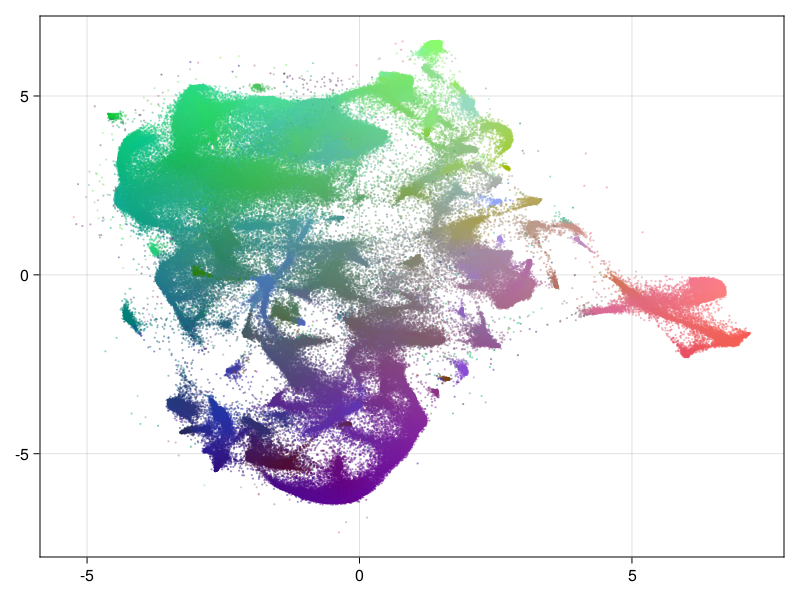

In [11]:
function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGBAf(c[1], c[2], c[3], 0.5) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    scatter(X, Y, color=C, markersize=3)
end

plot_umap(e2, e3)

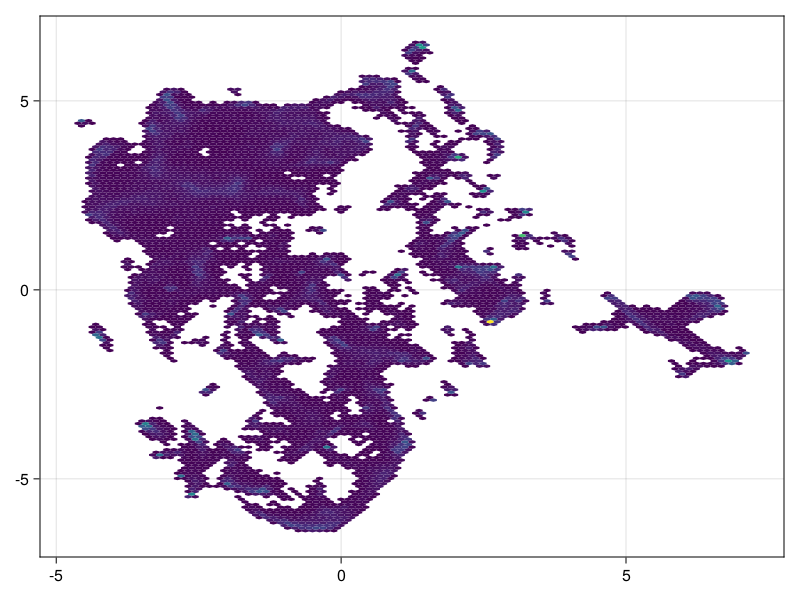

In [12]:
hexbin((@view e2[1, :]), (@view e2[2, :]); bins=200, threshold=10)

# Final notes

This example shows how to index and visualize the dataset using UMAP low dimensional projections. Low dimensional projections are made with `SimSearchManifoldLearning`, note that `SimilaritySearch` is also used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [13]:
Pkg.status()

Status `~/Research/SimilaritySearchDemos/WIT/Project.toml`
  [336ed68f] CSV v0.10.10
  [13f3f980] CairoMakie v0.10.5
  [35d6a980] ColorSchemes v3.21.0
  [5ae59095] Colors v0.12.10
  [a93c6f00] DataFrames v1.5.0
  [ac1192a8] HypertextLiteral v0.9.4
  [033835bb] JLD2 v0.4.31
  [ca7ab67e] SimSearchManifoldLearning v0.2.9
  [053f045d] SimilaritySearch v0.10.8
